# Minh Tuan Lam - Vision AI intern assignment - Cat and Dog classification

Link of the used dataset: https://www.kaggle.com/datasets/tongpython/cat-and-dog

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers, Sequential
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Use multiple GPUs
strategy = tf.distribute.MirroredStrategy()
print(f'We are using {strategy.num_replicas_in_sync} GPUs!')

We are using 2 GPUs!


In [3]:
# Define some constants
img_height = 224
img_width = 224

## Data preprocessing

First, we need to read the images and apply some data augmentation.

In [4]:
train_gen = ImageDataGenerator(
    # Normalize images
    rescale=1./255,
    horizontal_flip=True,
#     rotation_range=0.1,
    zoom_range=0.1,
    validation_split=0.1,
)
test_gen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator=train_gen.flow_from_directory(
    '/kaggle/input/cat-and-dog/training_set/training_set',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator=train_gen.flow_from_directory(
    '/kaggle/input/cat-and-dog/training_set/training_set',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)
test_generator=test_gen.flow_from_directory(
    '/kaggle/input/cat-and-dog/test_set/test_set',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

Found 7205 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


Visualize some images in the train set.

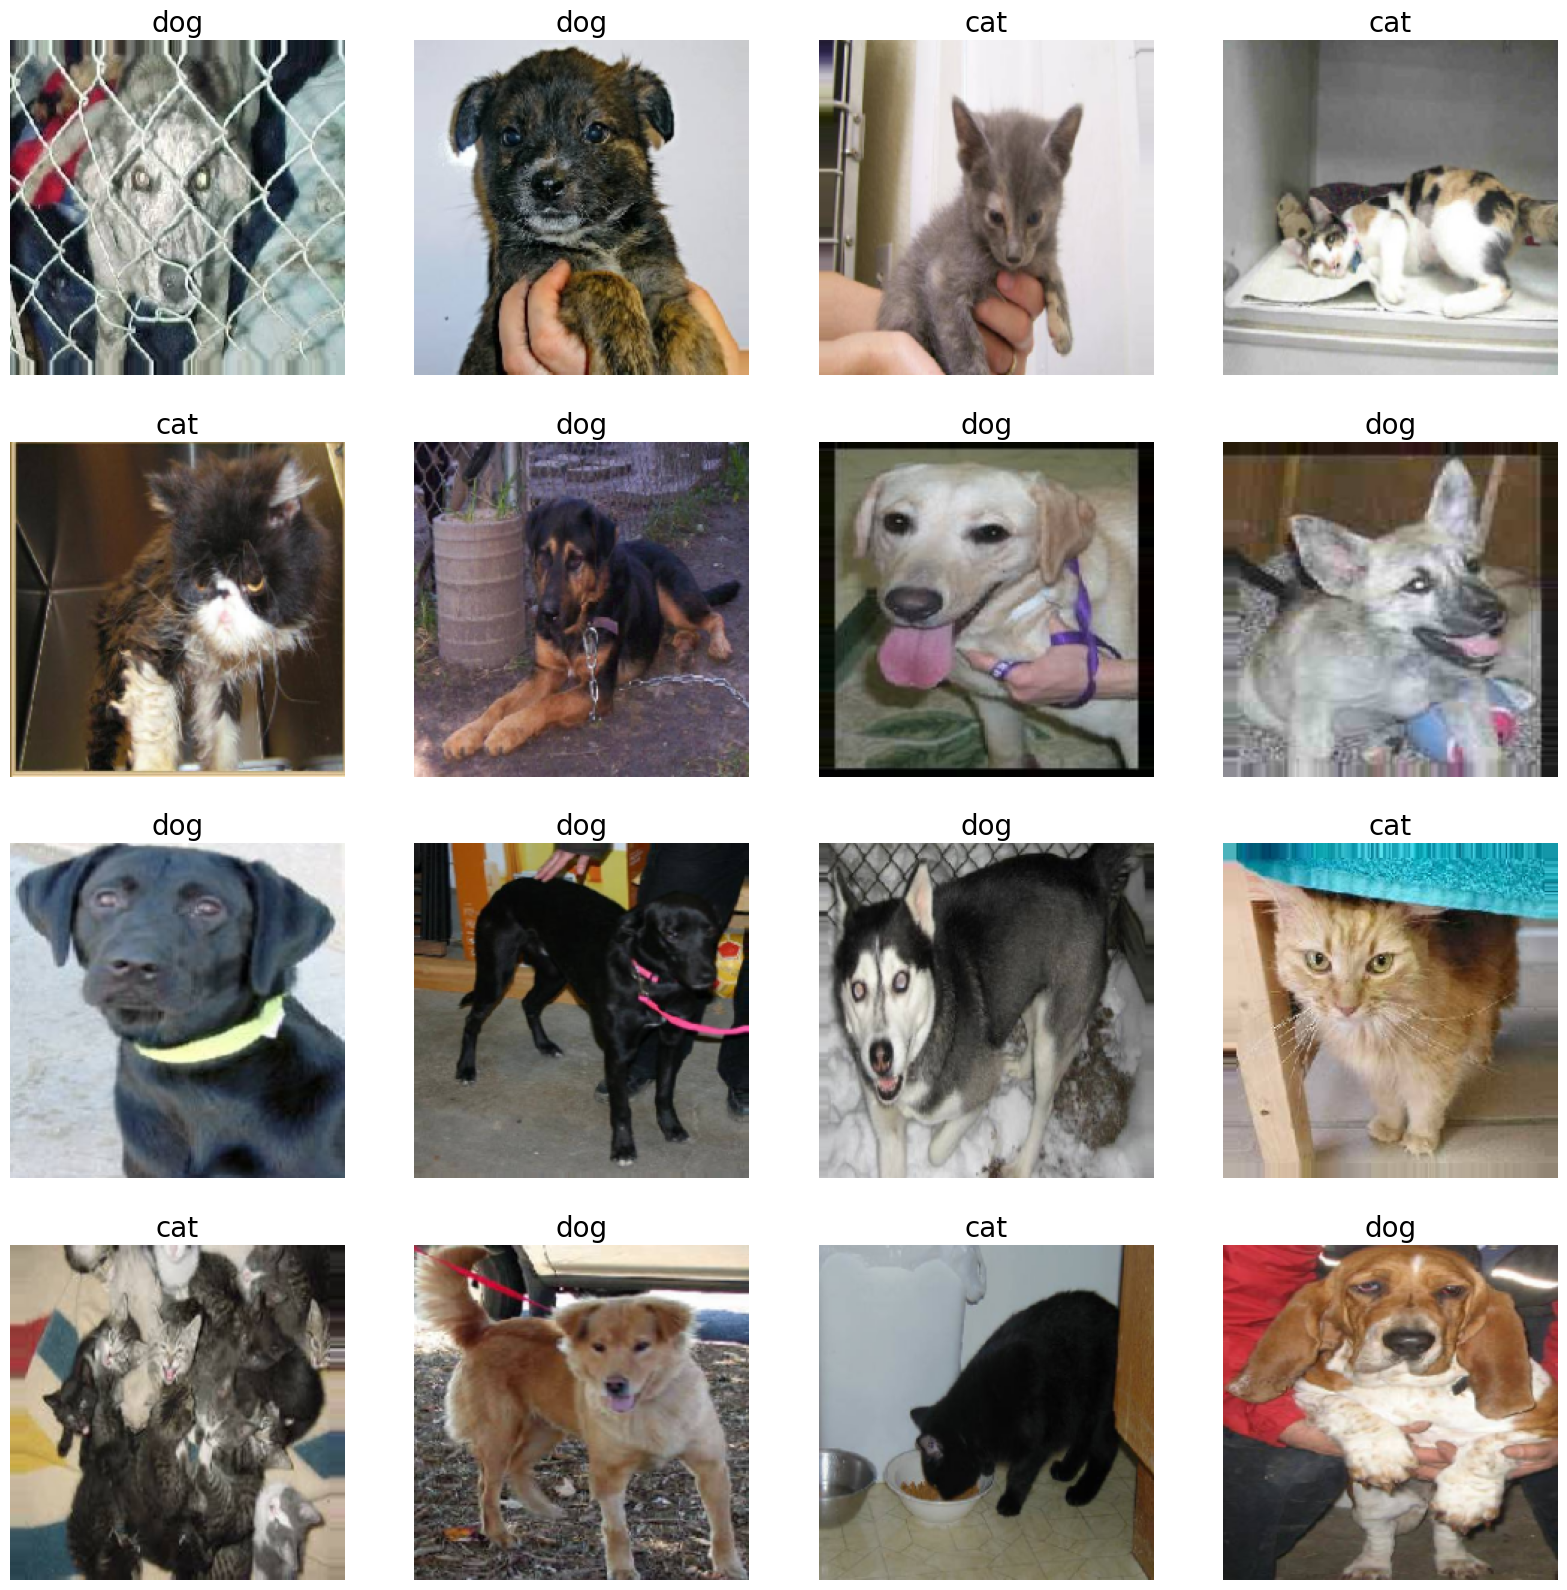

In [6]:

images, labels = train_generator.next()
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i in range(16):
    lb = 'cat' if labels[i] == 0 else 'dog'
    axs[i // 4, i % 4].imshow(images[i])
    axs[i // 4, i % 4].set_title(lb, fontsize=20)
    axs[i // 4, i % 4].axis('off')

# Model

We can use the technique called "transfer learning" and "fine-tuning" to take advantage of state-of-the-art models and save time. But in this assignment, I will build the model from scratch.

In [38]:
def build_model():
    model = Sequential([
        layers.Input(shape=(img_height, img_width, 3)),
        layers.Conv2D(32, (3, 3), padding='same', activation=layers.LeakyReLU(alpha=0.01)),
        layers.MaxPool2D((2, 2), 2),
        
        layers.Conv2D(64, (3, 3), padding='same', activation=layers.LeakyReLU(alpha=0.01)),
        layers.MaxPool2D((2, 2), 2),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation=layers.LeakyReLU(alpha=0.01)),
        layers.MaxPool2D((2, 2), 2),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation=layers.LeakyReLU(alpha=0.01)),
        layers.Dropout(0.2),
        layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01)),
        layers.Dense(16, activation=layers.LeakyReLU(alpha=0.01)),
        layers.Dense(2, activation='sigmoid')
    ])
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])
    return model


In [39]:
with strategy.scope():

    model = build_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 56, 56, 64)       256       
 hNormalization)                                                 
                                                      

In [40]:
# Early Stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [41]:
model.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[callback],)

Epoch 1/100
226/226 [==============================] - 104s 432ms/step - loss: 0.6684 - accuracy: 0.5782 - val_loss: 0.6799 - val_accuracy: 0.5863
Epoch 2/100
226/226 [==============================] - 98s 436ms/step - loss: 0.6553 - accuracy: 0.6000 - val_loss: 0.6559 - val_accuracy: 0.6087
Epoch 3/100
226/226 [==============================] - 98s 431ms/step - loss: 0.6528 - accuracy: 0.6071 - val_loss: 1.2825 - val_accuracy: 0.5088
Epoch 4/100
226/226 [==============================] - 98s 434ms/step - loss: 0.6396 - accuracy: 0.6230 - val_loss: 0.6741 - val_accuracy: 0.5337
Epoch 5/100
226/226 [==============================] - 101s 446ms/step - loss: 0.6297 - accuracy: 0.6397 - val_loss: 0.6758 - val_accuracy: 0.5713
Epoch 6/100
226/226 [==============================] - 98s 434ms/step - loss: 0.6106 - accuracy: 0.6644 - val_loss: 0.6212 - val_accuracy: 0.6450
Epoch 7/100
226/226 [==============================] - 98s 434ms/step - loss: 0.5963 - accuracy: 0.6794 - val_loss: 0.5839

In [42]:
model.save('/kaggle/working/classifier')

## Evaluate model

In [43]:
model.evaluate(test_generator)

64/64 [==============================] - 15s 237ms/step - loss: 0.4063 - accuracy: 0.8502


[0.4063260555267334, 0.8502224683761597]

We achieve accuracy near 90%!

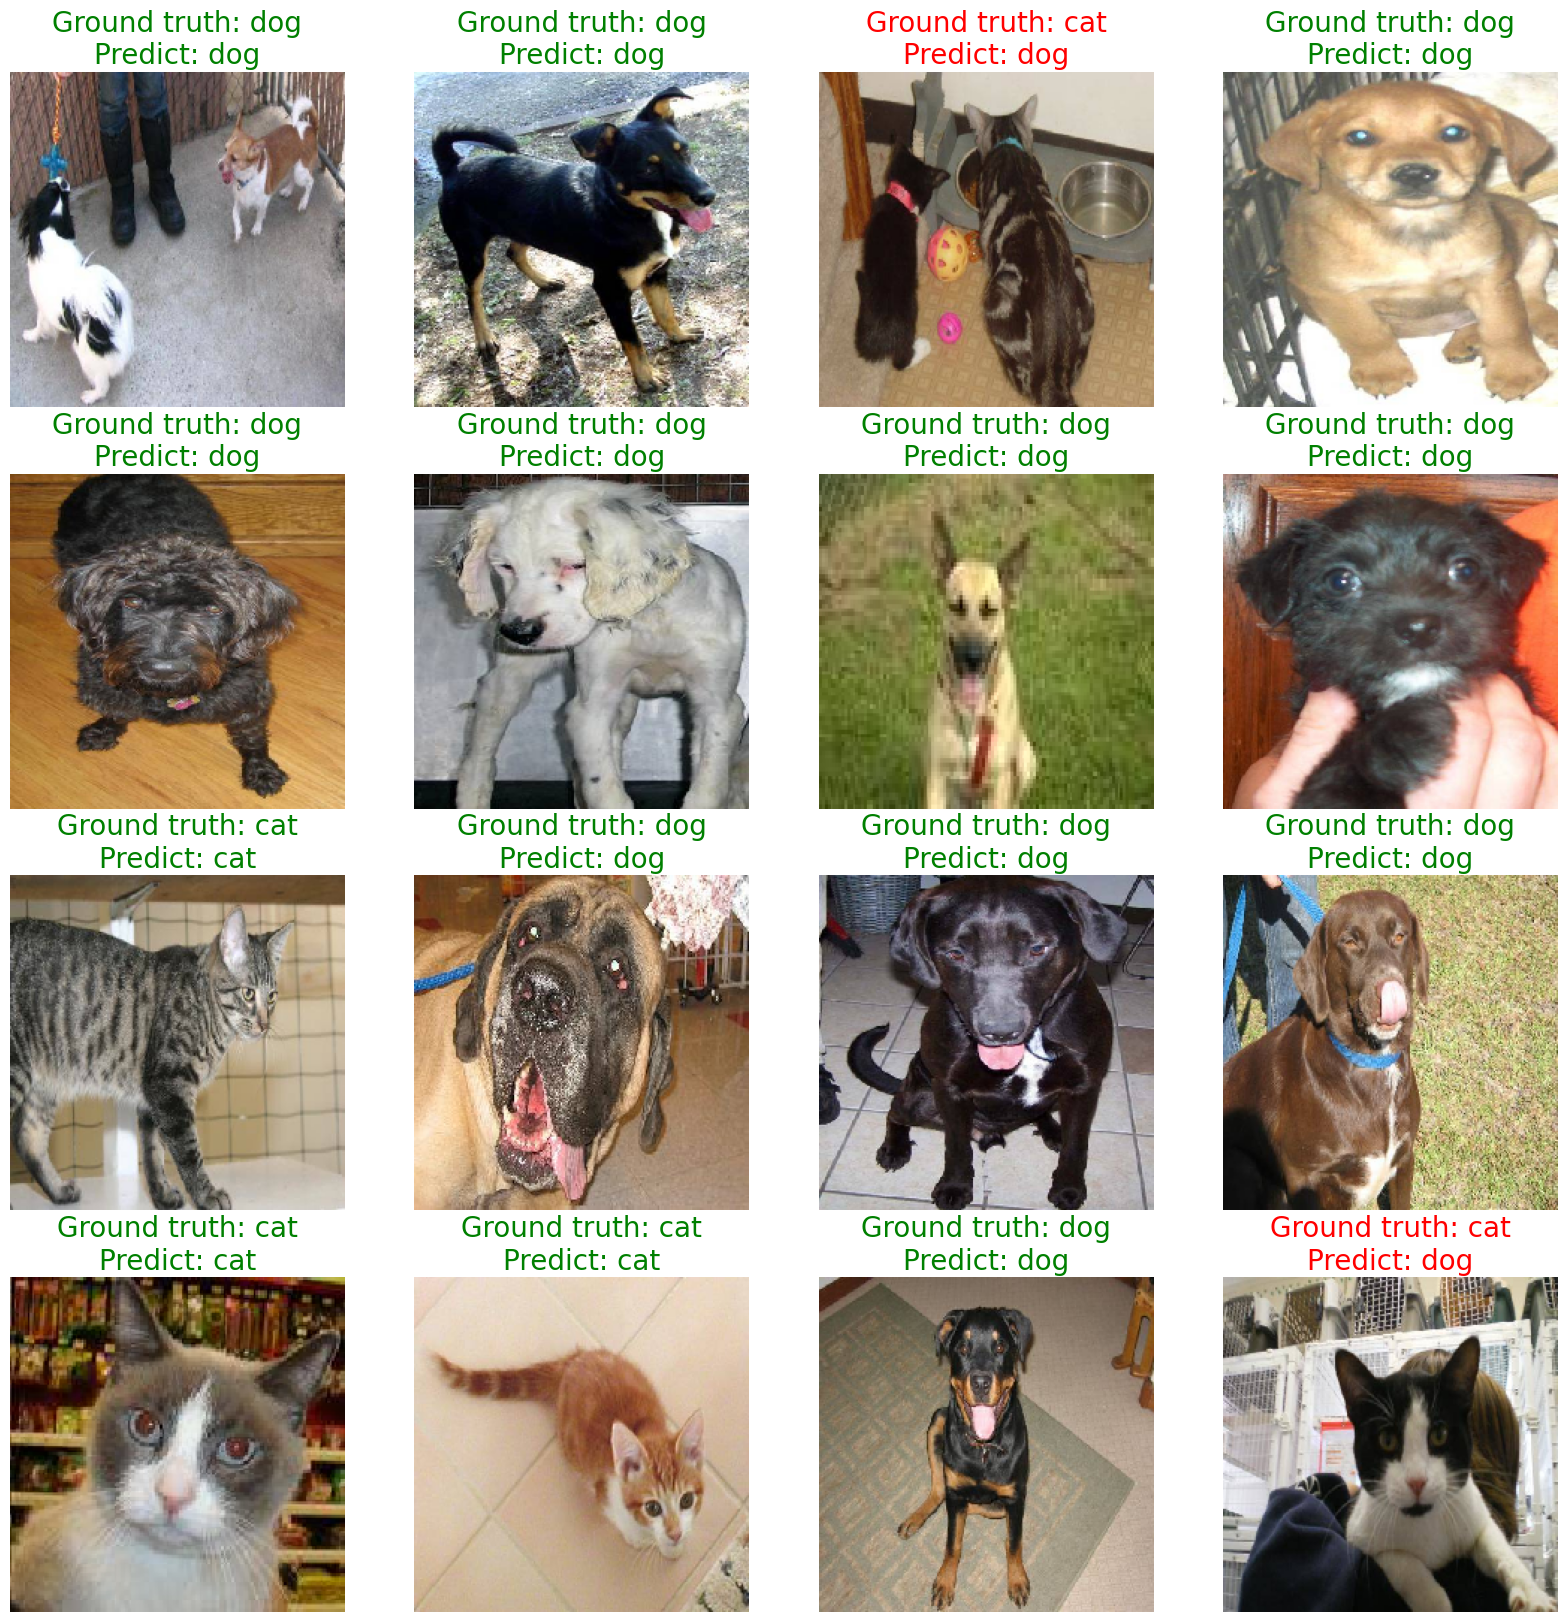

In [44]:
y_true = []
y_pred = []
plot = True
for i in range(len(test_generator)):
    images, labels = test_generator.next()
    y_true.extend(labels)
    prob = model.predict(images, verbose=0) 
    pred_class = np.argmax(prob, axis=1)
    y_pred.extend(pred_class)
    if plot:
        fig, axs = plt.subplots(4, 4, figsize=(20, 20))
        for j in range(16):
            pred_lb = 'cat' if pred_class[j] == 0 else 'dog'
            truth_lb = 'cat' if labels[j] == 0 else 'dog'
            color = 'green' if pred_lb == truth_lb else 'red'
            axs[j // 4, j % 4].imshow(images[j])
            axs[j // 4, j % 4].set_title(f'Ground truth: {truth_lb}\nPredict: {pred_lb}', fontsize=20, color=color)
            axs[j // 4, j % 4].axis('off')
    plot = False

In [45]:
len(y_pred) == len(y_true)

True

In [46]:
print('Classification report:\n ', classification_report(y_true, y_pred))

Classification report:
                precision    recall  f1-score   support

         0.0       0.85      0.86      0.85      1011
         1.0       0.85      0.84      0.85      1012

    accuracy                           0.85      2023
   macro avg       0.85      0.85      0.85      2023
weighted avg       0.85      0.85      0.85      2023



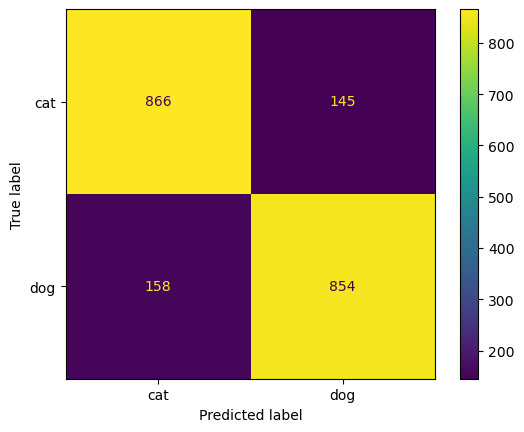

In [47]:
cfmt = confusion_matrix(y_true, y_pred )
disp = ConfusionMatrixDisplay(cfmt, display_labels=['cat', 'dog'])
disp.plot()

In [48]:
!zip -r '/kaggle/working/classifier.zip' '/kaggle/working/classifier'

  adding: kaggle/working/classifier/ (stored 0%)
  adding: kaggle/working/classifier/variables/ (stored 0%)
  adding: kaggle/working/classifier/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: kaggle/working/classifier/variables/variables.index (deflated 67%)
  adding: kaggle/working/classifier/fingerprint.pb (stored 0%)
  adding: kaggle/working/classifier/assets/ (stored 0%)
  adding: kaggle/working/classifier/keras_metadata.pb (deflated 93%)
  adding: kaggle/working/classifier/saved_model.pb (deflated 89%)
